In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt

data_folder = "recommendations"

files = sorted([f for f in os.listdir(data_folder) if f.startswith("hot_stocks") and f.endswith(".csv")])

print("Found files:")
for f in files:
    print(" -", f)

if not files:
    print("⚠ No daily hot stocks files found.")


Found files:
 - hot_stocks_20251115174433.csv
 - hot_stocks_20251117182242.csv
 - hot_stocks_20251117215705.csv
 - hot_stocks_20251117220812.csv
 - hot_stocks_20251118083059.csv
 - hot_stocks_20251118133929.csv
 - hot_stocks_20251118140312.csv
 - hot_stocks_20251118154352.csv


In [2]:
all_days = []

for f in files:
    date = f.split("_")[-1].split(".")[0]  # extract YYYYMMDD
    df = pd.read_csv(os.path.join(data_folder, f))
    df["date"] = date
    all_days.append(df)

full_df = pd.concat(all_days, ignore_index=True)

print("Loaded rows:", len(full_df))
full_df.head()


Loaded rows: 400


,symbol,regularMarketPrice,regularMarketChangePercent,regularMarketVolume,averageDailyVolume3Month,marketCap,VolumeSpike,MomentumScore,VolumeScore,VolatilityScore,TrendScore,HotScore,date
0,CDTX,217.71,105.40600,17287415.0,872168.0,6.844666e+09,19.821198,1.000000,1.000000,1.000000,0.971787,0.997179,20251115174433
1,SRRK,37.41,24.40970,6996750.0,2528325.0,3.596121e+09,2.767346,0.996865,0.962382,0.949843,0.761755,0.951881,20251115174433
2,ABVX,110.39,9.40535,2409287.0,1075398.0,8.591534e+09,2.240368,0.968652,0.924765,0.968652,0.943574,0.950784,20251115174433
3,LGN,40.27,20.85830,2813196.0,1162546.0,3.504975e+09,2.419858,0.990596,0.934169,0.940439,0.874608,0.949216,20251115174433
4,DASH,206.96,6.01916,11452141.0,3701549.0,8.413522e+10,3.093878,0.921630,0.968652,0.981191,0.912226,0.949060,20251115174433


In [3]:
# Columns we want to average
metrics = [
    "HotScore",
    "regularMarketChangePercent",
    "VolumeSpike",
    "MomentumScore",
    "VolumeScore",
    "VolatilityScore",
    "TrendScore"
]

avg_df = (full_df
          .groupby("symbol")[metrics]
          .mean()
          .sort_values("HotScore", ascending=False))

avg_df.head(20)


,HotScore,regularMarketChangePercent,VolumeSpike,MomentumScore,VolumeScore,VolatilityScore,TrendScore
symbol,,,,,,,
CDTX,0.997179,105.406000,19.821198,1.000000,1.000000,1.000000,0.971787
JAZZ,0.990146,20.623599,8.436004,0.992834,0.990442,0.992834,0.974327
NUVL,0.981277,12.032816,4.684670,0.985669,0.981489,0.974308,0.979101
PACS,0.964222,48.601135,11.303758,1.000000,0.996417,0.912742,0.829276
SQM,0.956363,8.963033,3.970006,0.976080,0.974323,0.900824,0.935570
AVDL,0.939969,22.453200,4.832060,0.993730,0.990596,0.887147,0.680251
ASND,0.937223,6.188031,1.789729,0.941554,0.891879,0.982086,0.991044
CSIQ,0.934953,17.330500,3.216826,0.987461,0.971787,0.899687,0.692790
EWTX,0.923197,11.410400,2.637086,0.981191,0.956113,0.811912,0.827586


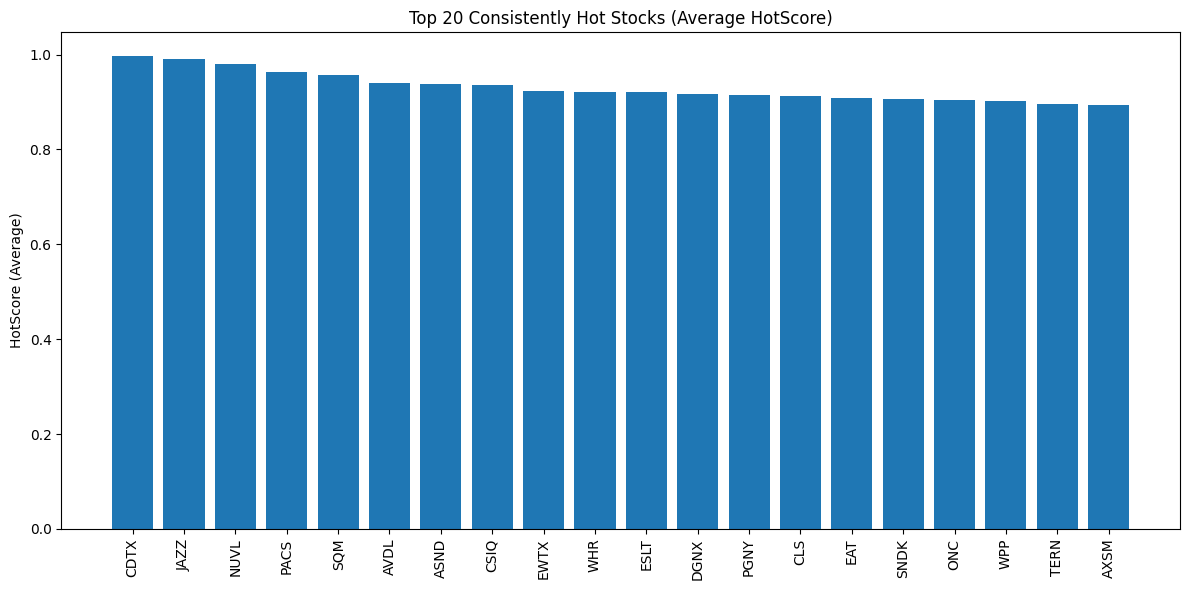

In [4]:
top20 = avg_df.head(20)

plt.figure(figsize=(12,6))
plt.bar(top20.index, top20["HotScore"])
plt.xticks(rotation=90)
plt.title("Top 20 Consistently Hot Stocks (Average HotScore)")
plt.ylabel("HotScore (Average)")
plt.tight_layout()
plt.show()


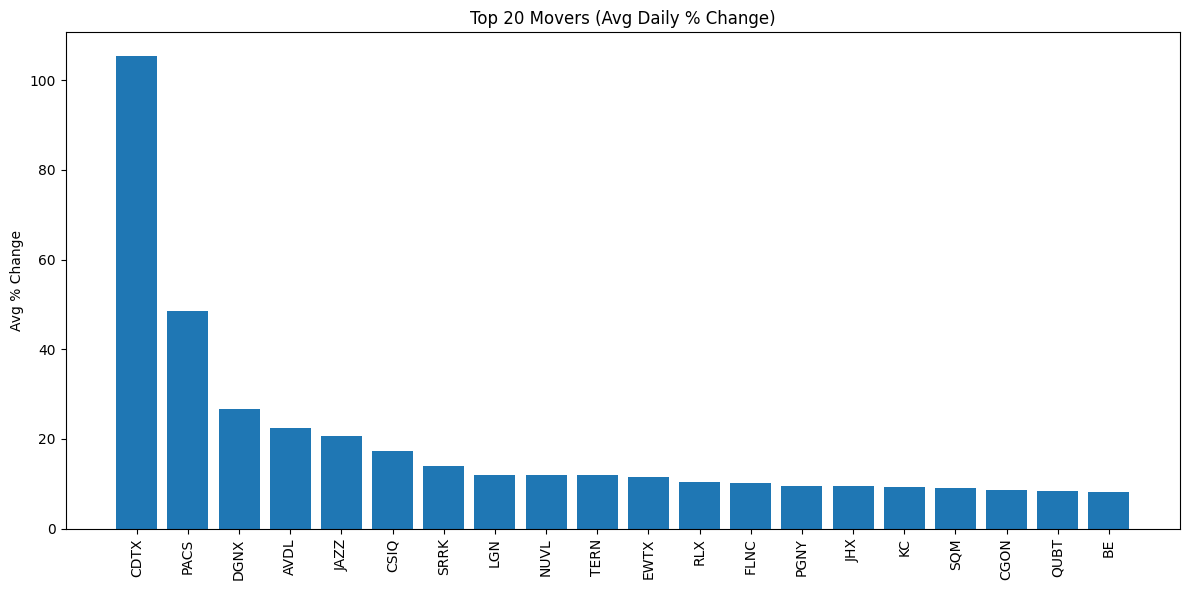

In [5]:
top20_move = avg_df.sort_values("regularMarketChangePercent", ascending=False).head(20)

plt.figure(figsize=(12,6))
plt.bar(top20_move.index, top20_move["regularMarketChangePercent"])
plt.xticks(rotation=90)
plt.title("Top 20 Movers (Avg Daily % Change)")
plt.ylabel("Avg % Change")
plt.tight_layout()
plt.show()


In [6]:
# Count appearances across days
appearances = full_df["symbol"].value_counts()

persistent = (
    pd.DataFrame({
        "Appearances": appearances,
        "AvgHotScore": avg_df["HotScore"]
    })
    .sort_values(["Appearances", "AvgHotScore"], ascending=False)
)

persistent.head(20)


,Appearances,AvgHotScore
symbol,,
TERN,8,0.895531
PACS,7,0.964222
DGNX,7,0.917006
SNDK,7,0.906901
DASH,7,0.887388
LNW,7,0.873410
ARQT,7,0.835699
GOOGL,7,0.808503
FIGR,7,0.789280
